<a href="https://colab.research.google.com/github/yun-feng/PrincipleCurve/blob/master/scRNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import files
uploaded = files.upload()

Saving scRNA_full.csv to scRNA_full (1).csv


In [48]:
import pandas as pd
import io
import numpy as np
df2 = pd.read_csv(io.BytesIO(uploaded['scRNA_full.csv']))
data=np.array(df2)
data=data[::20,]
print(data[:,2])
color_arr=data[:,2]
#color_arr=list(map(lambda x:x[0],color_arr.tolist()))
data=data[:,:2]/10

data=np.float64(data)
print(data)
print(data.shape)
N=data.shape[0]
print(N)
dist=np.zeros((N,N))


['r' 'r' 'r' ... 'k' 'k' 'k']
[[-0.61846913  0.22770921]
 [-0.53918682  0.22252172]
 [-0.64224958  0.25058279]
 ...
 [-0.57636962 -1.06638771]
 [-0.15731025  0.71564576]
 [-0.39793524 -0.22214728]]
(2682, 2)
2682


2:-515.1103313372975:[1336.8495281 1345.1504719]
2:-3270.1666647264506:[1842.41025289  839.58974711]
2:-3336.8165701224143:[1695.33451603  986.66548397]
2:-3353.295447293139:[1720.57206676  961.42793324]


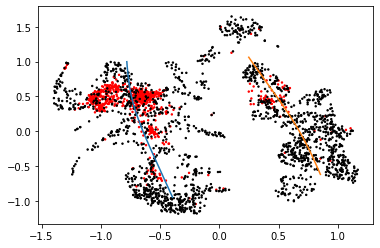

2:-3361.116115034166:[1674.84276147 1007.15723853]
2:-3364.638091858418:[1694.32066434  987.67933566]
2:-3366.8853985282462:[1670.88443896 1011.11556104]


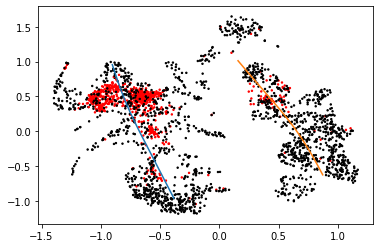

2:-3367.784656337331:[1680.98738189 1001.01261811]
2:-3368.6989045791656:[1667.0986587 1014.9013413]
2:-3369.0235129488265:[1672.62720211 1009.37279789]


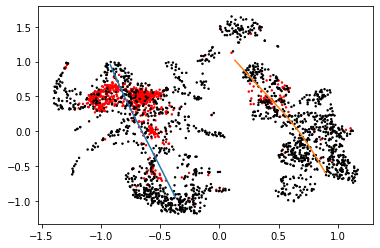

2:-3369.477390029652:[1663.94105006 1018.05894994]
2:-3369.64118537878:[1667.18070349 1014.81929651]


KeyboardInterrupt: ignored

In [83]:
#number of datapoints
N=data.shape[0]
#dimension of data
P=data.shape[1]


#hyper parameters
#velocity for curve
vel=[2.0,1.8]
#vel=[1.0,1.0,1.0,1.0,1.0]
vel=np.array(vel)
#number of intervals each curve divided into
Interval=200
#curvature regularizer
rho_delta=1e0*Interval
rho=(1/rho_delta)/2/Interval
#number of clusters
K=2
#Guassian mixture variance
#tradeoff between data fitting errors
sigma=0.3
#regularization parameters for model selection
#tradeoff between uniform distribution and laplacian distribution
log_k1=1e1
#tradeoff between cluster size differences
k2=10
#tradeoff between data fitting and number of curves
reg=0#1e3


#Variables
#origin for each curve
x_ori=np.random.random((P,K))
x_ori=np.float64([[-0.5,1.0],[-1.0,-0.5]])
#slope for each curve
alpha=np.ones((Interval,P,K))*np.random.random((P,K))
alpha=np.ones((Interval,P,K))*np.float64([[0,0],[1,1]])
alpha/=np.sqrt((np.square(alpha)).sum(1))[:,np.newaxis,:]/vel
#curve points position
x=np.zeros((Interval,P,K))+x_ori+np.cumsum(alpha,axis=0)*1.0/Interval
#clustering probabilities
z=np.random.random((N,K))
z/=z.sum(1)[:,np.newaxis]
#distance between datapoints and curve points
dist=np.zeros((N,Interval,K))
#pseudotime probabilities
pseudotime_prob=np.random.random((N,Interval,K))
pseudotime_prob/=pseudotime_prob.sum(1)[:,np.newaxis,:]
import matplotlib.pyplot as plt
for cycle in range(10000):
	
	dist=np.square(data[:,np.newaxis,:,np.newaxis]-x[np.newaxis,:,:,:]).sum(2)
	
	softmin_val_t=dist.min(1)
	pseudotime_prob=np.exp((-dist+softmin_val_t[:,np.newaxis,:])/sigma)
	
	
	group_loss=-np.log(pseudotime_prob.sum(1))+softmin_val_t/sigma
	softmin_val_group=group_loss.min(1)
	group_loss-=softmin_val_group[:,np.newaxis]
	
	pseudotime_prob/=pseudotime_prob.sum(1)[:,np.newaxis,:]
	
	group_L2=np.sqrt((np.square(z)).sum(0))
	
	Loss=(z*group_loss).sum()+(z*np.log(z)).sum()+softmin_val_group.sum()-reg*np.log(1+np.exp(log_k1-k2*group_L2)).sum()
	Loss*=sigma
	Loss+=rho_delta*np.square(np.diff(alpha,axis=0)).sum()
	print(str(K)+":"+str(Loss)+":"+str(z.sum(0)))
	
	group_reg=reg*(np.exp(log_k1-k2*group_L2))/(1.0+np.exp(log_k1-k2*group_L2))*k2/(2*group_L2)
	max_weight=group_reg.max()
	dual_varaible=group_reg*z-max_weight-max_weight*np.log(z)
	z=np.exp(-(group_loss+2*dual_varaible)/(1+2*max_weight))
	z/=z.sum(1)[:,np.newaxis]
	#optimize x_ori
	data_center=(data[:,:,np.newaxis]*z[:,np.newaxis,:]).sum(0)
	x_center=(x[np.newaxis,:,:,:]*z[:,np.newaxis,np.newaxis,:]*pseudotime_prob[:,:,np.newaxis,:]).sum((0,1))
	shift=(data_center-x_center)/(z.sum(0))
	x_ori+=shift
	x=x+shift
	
	#optimize alpha with Householder matrices
	for k in range(K):
		#pivot
		pivot_x=x_ori[:,k]
		for i in range(Interval):
			#Linear loss 
			S=-((x[np.newaxis,i:,:,k]-pivot_x)*z[:,np.newaxis,np.newaxis,k]*pseudotime_prob[:,i:,np.newaxis,k]).sum(1)
			S=(S[:,:,np.newaxis]*(data[:,np.newaxis,:]-pivot_x)).sum(0)#np.dot(S.transpose(),data)
			if i>0:
				S-=rho_delta*alpha[i,:,k,np.newaxis]*alpha[np.newaxis,i-1,:,k]
			#random direction
			n=np.random.random(P)
			n/=np.sqrt(np.square(n).sum())
			ori=np.copy(n)
			S=S-2*np.dot(n[:,np.newaxis]*n[np.newaxis,:],S)+S.transpose()-2*np.dot(S.transpose(),n[:,np.newaxis]*n[np.newaxis,:])
			n=np.sum(np.abs(S))*n+np.dot(S,n)
			n/=np.sqrt(np.square(n).sum())
			#Orthonomal matirx
			Rotate_P=-2*ori[:,np.newaxis]*ori[np.newaxis,:]-2*n[:,np.newaxis]*n[np.newaxis,:]+4*np.sum(ori*n)*ori[:,np.newaxis]*n[np.newaxis,:]
			alpha[i:,:,k]=alpha[i:,:,k]+np.dot(alpha[i:,:,k],Rotate_P)
			x[i:,:,k]=x[i:,:,k]+np.dot(x[i:,:,k]-pivot_x,Rotate_P)
			
			pivot_x=pivot_x+alpha[i,:,k]*1.0/Interval
	temp=np.concatenate((x_ori[np.newaxis,:,:],x),axis=0)
	temp=temp[::-1,:,:]
	x_ori=temp[0]
	x=temp[1:]
	alpha=-alpha[::-1]
	if(cycle>1 and np.min(z.sum(0))<0.05*N):
		#plt.scatter(data[:,0],data[:,1],c="k",s=3)
		#for k in range(K):
		# plt.plot(x[:,0,k],x[:,1,k])
		#plt.show()
		K-=1
		
		i=np.argmin(z.sum(0))
		x_ori=np.concatenate((x_ori[:,:i],x_ori[:,i+1:]),axis=1)
		alpha=np.concatenate((alpha[:,:,:i],alpha[:,:,i+1:]),axis=2)
		x=np.concatenate((x[:,:,:i],x[:,:,i+1:]),axis=2)
		z=np.concatenate((z[:,:i],z[:,i+1:]),axis=1)
		z/=z.sum(1)[:,np.newaxis]
	if cycle>0 and cycle%3==0:
		plt.scatter(data[:,0],data[:,1],c=color_arr,s=2)
		for k in range(K):plt.plot(x[:,0,k],x[:,1,k])
		plt.show()

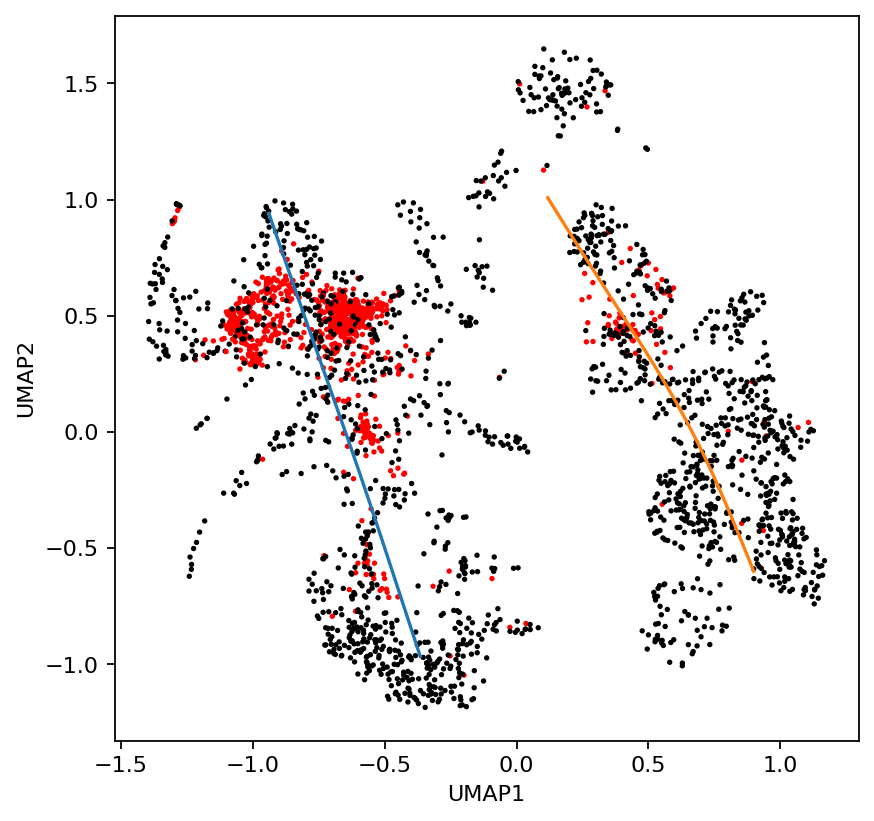

In [84]:
plt.figure(num=None, figsize=(6,6), dpi=160, facecolor='w', edgecolor='k')
plt.scatter(data[:,0],data[:,1],c=color_arr,s=2)
for k in range(K):plt.plot(x[:,0,k],x[:,1,k])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

In [89]:
print(z.shape)
print(pseudotime_prob.shape)
from google.colab import files
uploaded = files.upload()


(2682, 2)
(2682, 200, 2)


Saving expression.csv to expression.csv


In [134]:
df = pd.read_csv(io.BytesIO(uploaded['expression.csv']))
wkdata=np.array(df)
print(sum(z[color_arr=="r",:],0))
cluster=np.argmax(sum(z[color_arr=="r",:],0))
print(cluster)
cancer=wkdata[:,(color_arr=="r") & (z[:,cluster]>0.7)]
print(cancer.shape)
normal=wkdata[:,(color_arr=="k") & (z[:,cluster]>0.7)]
print(normal.shape)
timing=np.array(range(Interval))
pseudotime=(pseudotime_prob[:,:,cluster]*timing).sum(1)
pseudotime_normal=pseudotime[(color_arr=="k") & (z[:,cluster]>0.7)]
pseudotime_cancer=pseudotime[(color_arr=="r") & (z[:,cluster]>0.7)]
print(pseudotime_cancer.shape,pseudotime_normal.shape)

diff=np.zeros(cancer.shape[0])
for i in range(cancer.shape[1]):
  weight=np.exp(-(pseudotime_normal-pseudotime_cancer[i])**2)
  weight/=weight.sum()
  diff+=cancer[:,i]-(normal*weight).sum(1)

[798.00842078 104.99157922]
0
(335, 822)
(335, 834)
(822,) (834,)


In [136]:
print(diff)
np.savetxt("diff.csv", diff, delimiter=",")

[ 9.11389776e+02  3.10141025e+02 -3.02863144e+03  4.57745874e+03
 -2.43703140e+03  2.07190780e+03  1.13478591e+02 -1.30412381e+03
 -8.51761243e+02 -1.75931845e+03 -1.33383690e+01  1.01059288e+03
 -5.32867992e+02 -2.26025253e+02 -2.40458181e+02  4.00778584e+02
 -3.81978998e+02 -1.38950546e+02  9.91750750e+02 -1.75574810e+02
  1.98024560e+02 -2.84148554e+02  6.96624313e+02  2.24816881e+02
  8.24513850e+02 -1.57451130e+03 -1.20781392e+03 -7.38238997e+02
  1.70278330e+03  2.64456598e+02 -2.47727539e+02 -3.88527200e+02
  1.56830797e+02 -1.35832892e+02 -1.03332702e+03 -1.56657779e+03
  4.81296956e+01 -2.55950768e+02  3.74078328e+01  4.66342519e+02
 -8.91055268e+01 -1.18664973e+01  5.68966676e+01 -3.74788206e+02
 -6.32704383e+02  2.76526880e+02 -8.27455774e+02 -4.81001924e+02
 -8.53599724e+03 -8.23990323e+00  3.17794109e+02 -1.17607992e+03
 -8.95261540e+03  7.64725197e+01  7.26134953e+02 -4.57193657e+02
 -4.22646316e+02  4.42294650e+02 -5.11711966e+02 -1.59220648e+01
  3.17677761e+02 -4.57643

In [0]:
from google.colab import files
files.download('diff.csv')